In [ ]:
# Preparation
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequentialvoca
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# Preparation
nltk.download('stopwords')

In [3]:
# Preparation
# DATASET
DATASET_COLUMNS = ["ids", 'text', "target"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.9

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.3, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
## Training Part
dataset_path = os.path.join("train.csv")
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING)

Open file: train.csv


/Users/yx4247/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print("Dataset size:", len(df))

Dataset size: 402755


In [6]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 456 ms, sys: 23.3 ms, total: 480 ms
Wall time: 196 ms


In [8]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

Text(0.5,1,'Dataset labels distribuition')

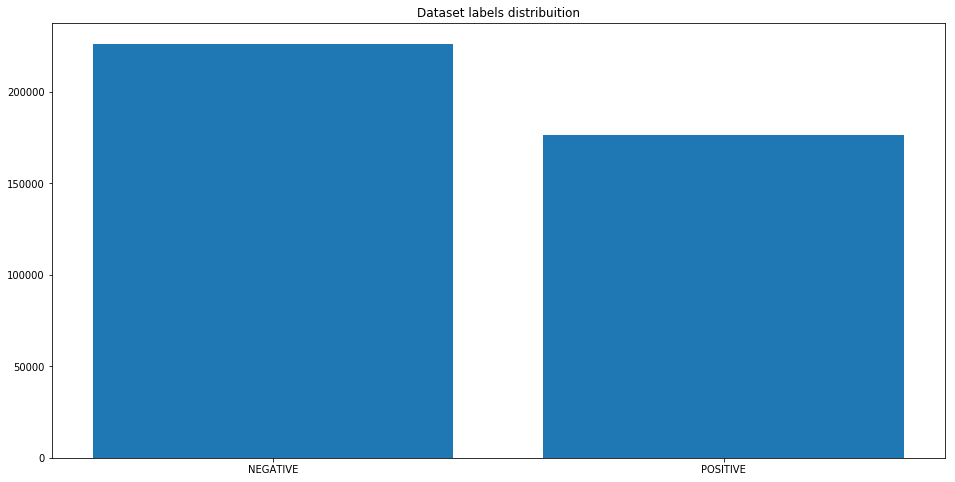

In [9]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [10]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [11]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [12]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 17 s, sys: 127 ms, total: 17.1 s
Wall time: 17.2 s


In [13]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
#print("TRAIN size:", len(df_train))
#print("TEST size:", len(df_test))
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 362479
TEST size: 40276


In [14]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 1.11 s, sys: 117 ms, total: 1.23 s
Wall time: 1.24 s


In [15]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [16]:
w2v_model.build_vocab(documents)

2019-05-17 10:16:08,364 : INFO : collecting all words and their counts
2019-05-17 10:16:08,365 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-05-17 10:16:08,393 : INFO : PROGRESS: at sentence #10000, processed 93594 words, keeping 11697 word types
2019-05-17 10:16:08,422 : INFO : PROGRESS: at sentence #20000, processed 187171 words, keeping 16786 word types
2019-05-17 10:16:08,448 : INFO : PROGRESS: at sentence #30000, processed 281514 words, keeping 20814 word types
2019-05-17 10:16:08,478 : INFO : PROGRESS: at sentence #40000, processed 373891 words, keeping 24124 word types
2019-05-17 10:16:08,514 : INFO : PROGRESS: at sentence #50000, processed 468143 words, keeping 26964 word types
2019-05-17 10:16:08,547 : INFO : PROGRESS: at sentence #60000, processed 562236 words, keeping 29448 word types
2019-05-17 10:16:08,582 : INFO : PROGRESS: at sentence #70000, processed 656437 words, keeping 31845 word types
2019-05-17 10:16:08,624 : INFO : PROGRESS: at s

In [17]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 14057


In [18]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-05-17 10:16:09,943 : INFO : training model with 8 workers on 14057 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-05-17 10:16:10,970 : INFO : EPOCH 1 - PROGRESS: at 37.25% examples, 1026931 words/s, in_qsize 16, out_qsize 1
2019-05-17 10:16:12,002 : INFO : EPOCH 1 - PROGRESS: at 74.43% examples, 1017164 words/s, in_qsize 13, out_qsize 2
2019-05-17 10:16:12,658 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-05-17 10:16:12,661 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-05-17 10:16:12,662 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-05-17 10:16:12,663 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-05-17 10:16:12,667 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-05-17 10:16:12,678 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-05-17 10:16:12,682 : INFO : worker thread finished; awaiting finish o

2019-05-17 10:16:32,152 : INFO : EPOCH - 7 : training on 3409065 raw words (2793848 effective words) took 3.0s, 933844 effective words/s
2019-05-17 10:16:33,172 : INFO : EPOCH 8 - PROGRESS: at 28.75% examples, 799711 words/s, in_qsize 14, out_qsize 1
2019-05-17 10:16:34,177 : INFO : EPOCH 8 - PROGRESS: at 59.27% examples, 823573 words/s, in_qsize 15, out_qsize 0
2019-05-17 10:16:35,184 : INFO : EPOCH 8 - PROGRESS: at 86.48% examples, 801216 words/s, in_qsize 14, out_qsize 0
2019-05-17 10:16:35,613 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-05-17 10:16:35,617 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-05-17 10:16:35,621 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-05-17 10:16:35,626 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-05-17 10:16:35,634 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-05-17 10:16:35,636 : INFO : worker thread finished; awaiting 

2019-05-17 10:16:55,417 : INFO : EPOCH 15 - PROGRESS: at 76.17% examples, 1048612 words/s, in_qsize 14, out_qsize 1
2019-05-17 10:16:55,947 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-05-17 10:16:55,957 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-05-17 10:16:55,960 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-05-17 10:16:55,962 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-05-17 10:16:55,963 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-05-17 10:16:55,970 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-05-17 10:16:55,979 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-05-17 10:16:55,985 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-05-17 10:16:55,986 : INFO : EPOCH - 15 : training on 3409065 raw words (2792636 effective words) took 2.6s, 1074222 effective words/s
2019-05-17 10:16:

2019-05-17 10:17:15,504 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-05-17 10:17:15,506 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-05-17 10:17:15,510 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-05-17 10:17:15,520 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-05-17 10:17:15,520 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-05-17 10:17:15,522 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-05-17 10:17:15,523 : INFO : EPOCH - 22 : training on 3409065 raw words (2793638 effective words) took 2.6s, 1077962 effective words/s
2019-05-17 10:17:16,541 : INFO : EPOCH 23 - PROGRESS: at 27.28% examples, 758987 words/s, in_qsize 15, out_qsize 0
2019-05-17 10:17:17,546 : INFO : EPOCH 23 - PROGRESS: at 64.50% examples, 896524 words/s, in_qsize 15, out_qsize 0
2019-05-17 10:17:18,379 : INFO : worker thread finished; awaiting finish of 7 more th

2019-05-17 10:17:35,158 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-05-17 10:17:35,159 : INFO : EPOCH - 29 : training on 3409065 raw words (2793976 effective words) took 2.6s, 1094542 effective words/s
2019-05-17 10:17:36,179 : INFO : EPOCH 30 - PROGRESS: at 36.96% examples, 1024676 words/s, in_qsize 14, out_qsize 1
2019-05-17 10:17:37,183 : INFO : EPOCH 30 - PROGRESS: at 77.94% examples, 1083094 words/s, in_qsize 14, out_qsize 1
2019-05-17 10:17:37,691 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-05-17 10:17:37,706 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-05-17 10:17:37,708 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-05-17 10:17:37,720 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-05-17 10:17:37,727 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-05-17 10:17:37,731 : INFO : worker thread finished; awaiting finish of 2 more 

CPU times: user 7min, sys: 3.65 s, total: 7min 4s
Wall time: 1min 33s


(89384620, 109090080)

In [19]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 70520
CPU times: user 6.99 s, sys: 67.1 ms, total: 7.06 s
Wall time: 7.11 s


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 8.47 s, sys: 352 ms, total: 8.82 s
Wall time: 8.93 s


In [21]:
labels = df_train.target.unique().tolist()
labels

['NEGATIVE', 'POSITIVE']

In [22]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (362479, 1)
y_test (40276, 1)


In [23]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(70520, 300)


In [24]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.


2019-05-17 10:17:59,757 : WARNING : From /Users/yx4247/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-05-17 10:18:00,263 : WARNING : From /Users/yx4247/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          21156000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 21,316,501
Trainable params: 160,501
Non-trainable params: 21,156,000
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [27]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [28]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.


2019-05-17 10:18:00,732 : WARNING : From /Users/yx4247/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 326231 samples, validate on 36248 samples
Epoch 1/8
 55296/326231 [====>.........................] - ETA: 32:13 - loss: 0.4555 - acc: 0.7826

KeyboardInterrupt: 

In [29]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

40276/40276 [==============================] - 72s 2ms/step

ACCURACY: 0.9325901282639901
LOSS: 0.18520327364070044
CPU times: user 5min 38s, sys: 1min 48s, total: 7min 26s
Wall time: 1min 12s


In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'history' is not defined

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)